In [1]:
# # https://blaylockbk.github.io/goes2go/_build/html/reference_guide/index.html#rgb-recipes
# from goes2go.data import goes_latest
# import matplotlib.pyplot as plt
# import cartopy.crs as ccrs

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


In [2]:
# Download a GOES ABI dataset
# G = goes_latest(satellite='noaa-goes16', product='ABI-L2-MCMIP', domain='C', return_as='xarray',
#                 download=True, overwrite=False,
#                 s3_refresh=True, verbose=True)
# OR_ABI-L2-CMIPM1-M3C02_G16_s20171931811268_e20171931811326_c20171931811393.nc

In [3]:
# Read in Level 2 NetCDF
# ref_ch2 = G.variables['CMI'][:]
# g16nc.close()
# g16nc = None

In [4]:
# Download the utilities.py script, created by INPE (contains some useful functions for processing GOES-R data)
# !wget -c https://www.dropbox.com/s/i8j1g9xg1g7o56l/utilities.py

(<osgeo.gdal.GDALWarpAppOptions; proxy of <Swig Object of type 'GDALWarpAppOptions *' at 0x7fd4b6467c00> >, None, None)
applying gamma corr
gamma corr applied


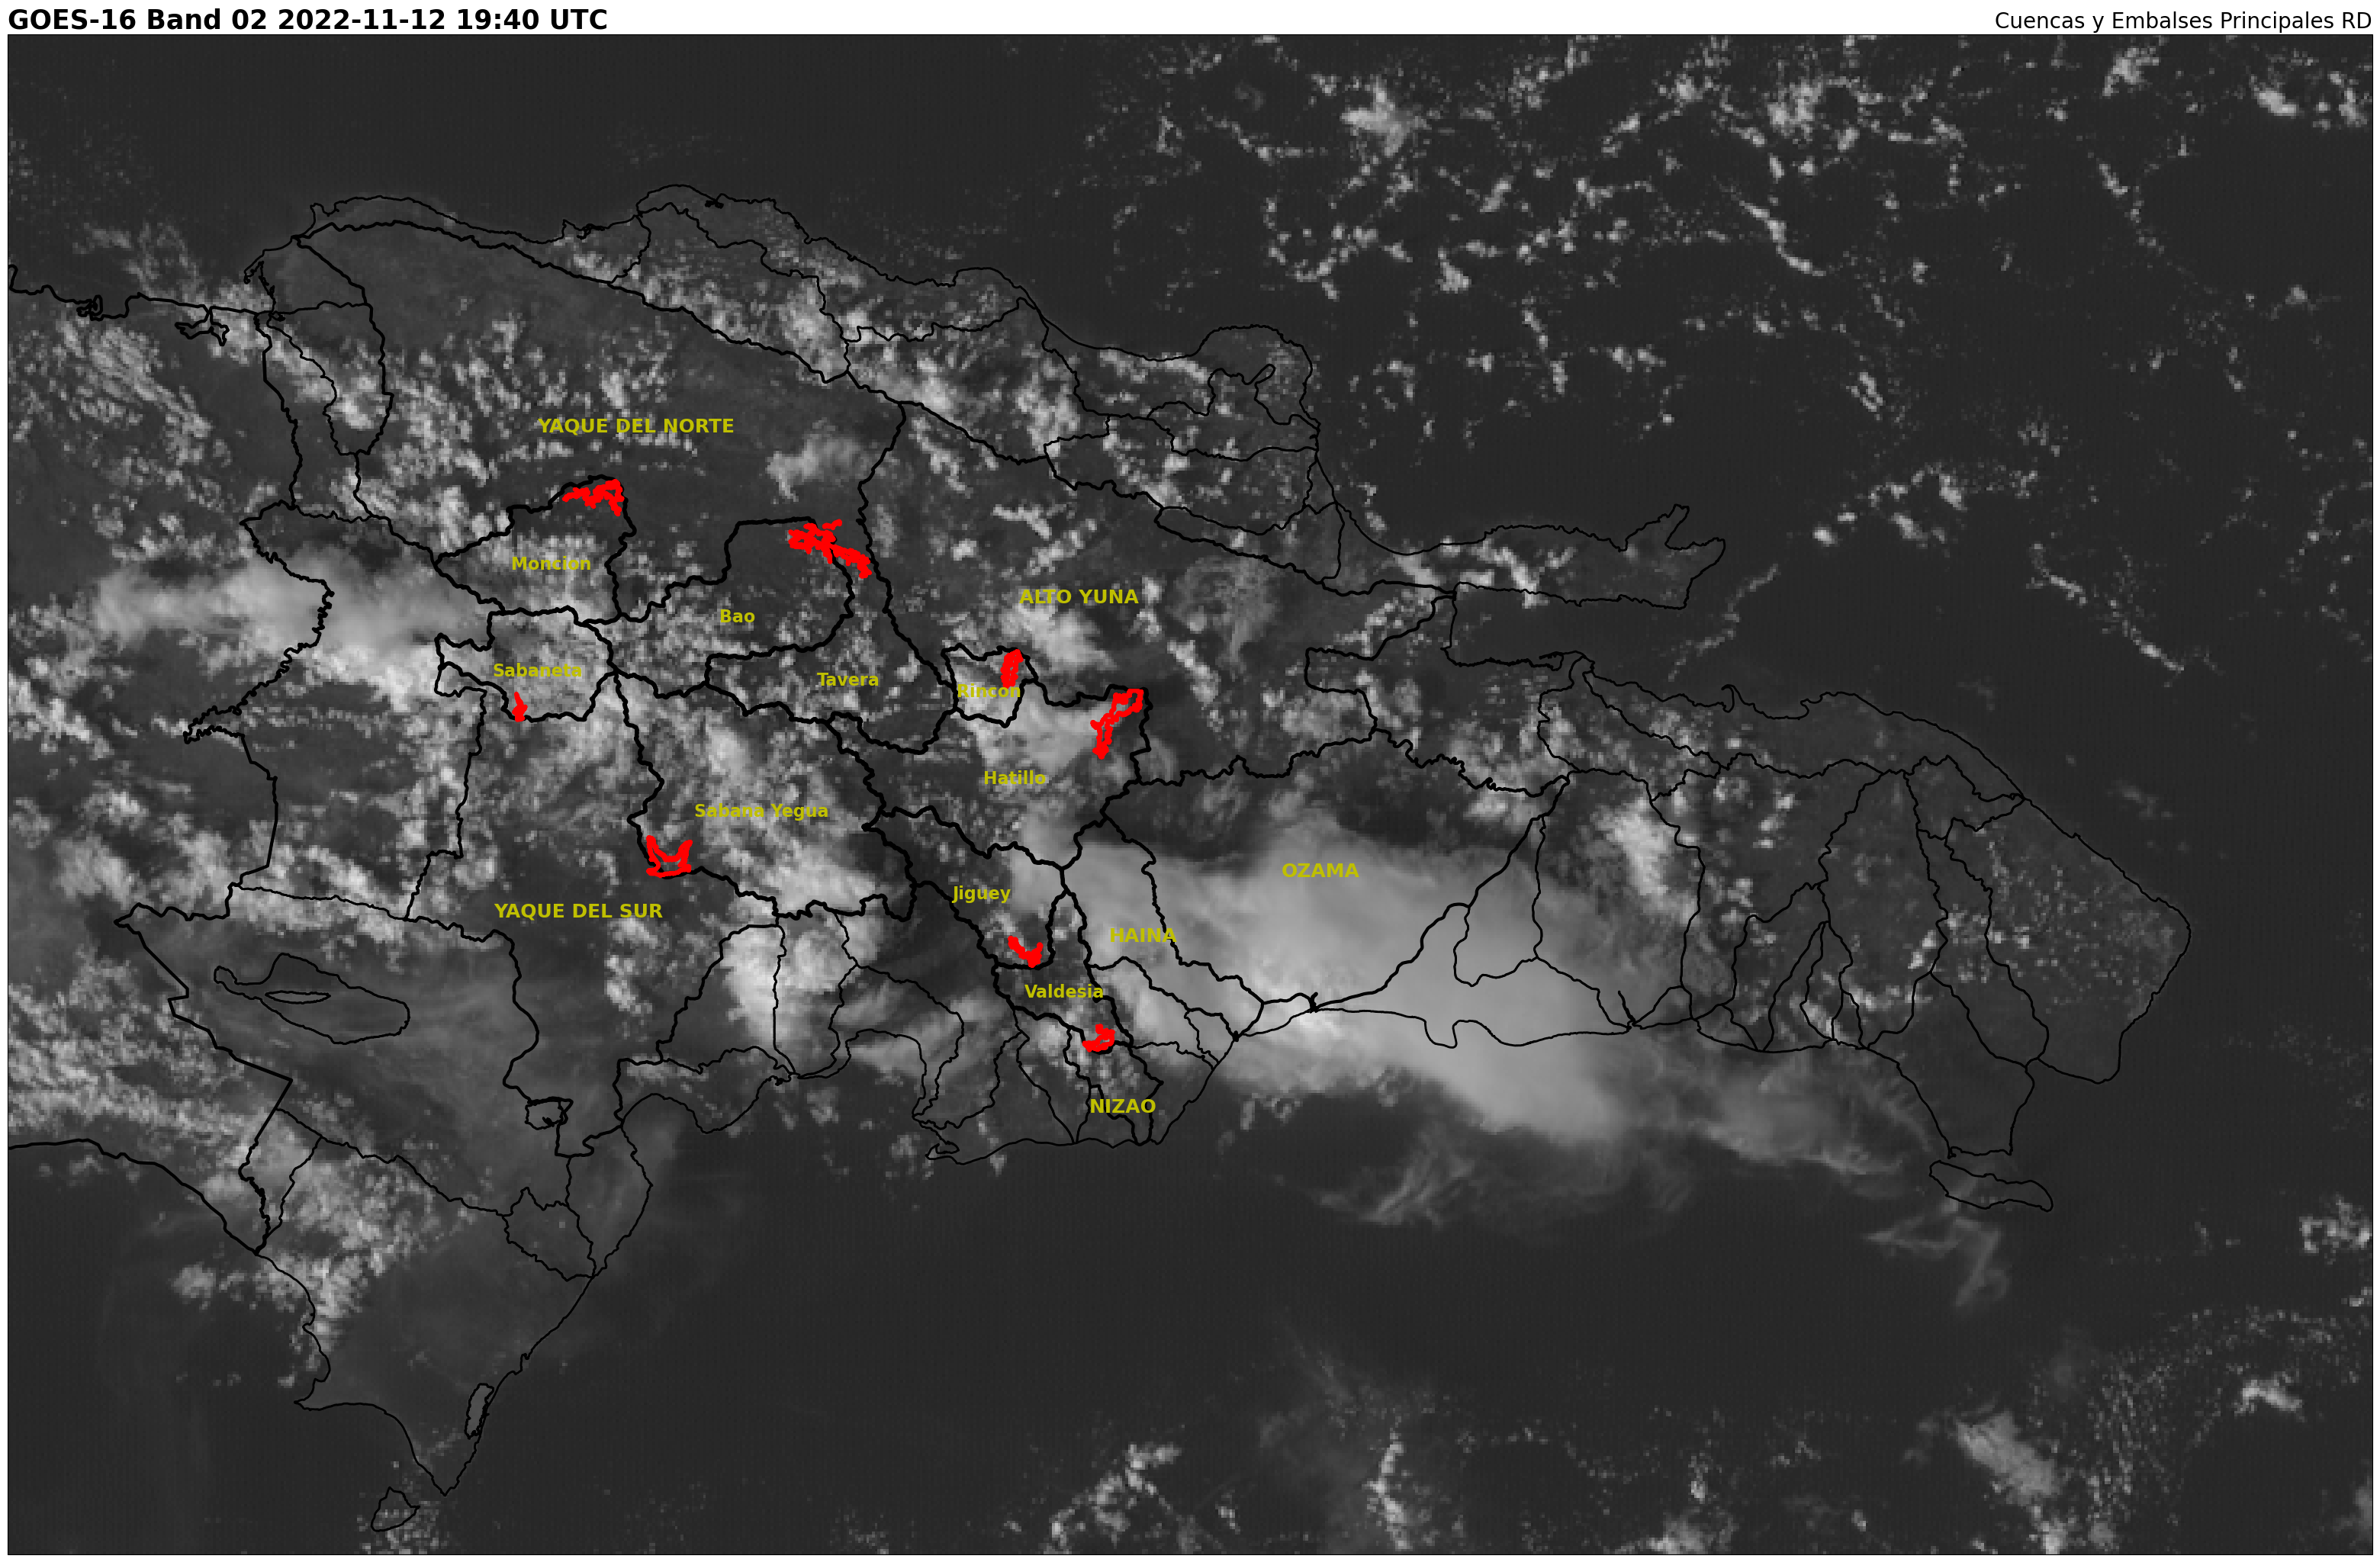

In [1]:
# -----------------------------------------------------------------------------------------------------------
# INPE / CPTEC - Training: Python and GOES-R Imagery: Script 14 - Reprojection with GDAL
# -----------------------------------------------------------------------------------------------------------
# Required modules
import os  # Miscellaneous operating system interfaces
from datetime import datetime  # Basic Dates and time types

import cartopy
import cartopy.crs as ccrs  # Plot maps
import cartopy.io.shapereader as shpreader  # Import shapefiles
import geopandas
import matplotlib.pyplot as plt  # Plotting library
import numpy as np  # Scientific computing with Python
from netCDF4 import Dataset  # Read / Write NetCDF4 files
from osgeo import gdal  # Python bindings for GDAL
from osgeo import osr  # Python bindings for GDAL
from utilities import download_CMI  # Our function for download

# -----------------------------------------------------------------------------------------------------------
# Input and output directories
input = "./content/Samples"
os.makedirs(input, exist_ok=True)
output = "./content/Output"
os.makedirs(output, exist_ok=True)

# Desired extent
extent = [-140.0, 10.0, -60.0, 60.0]  # Min lon, Min lat, Max lon, Max lat

# Datetime to process
yyyymmddhhmn = "202211121940"
band = "02"

# Download the file
file_name = download_CMI(yyyymmddhhmn, band, input)

# -----------------------------------------------------------------------------------------------------------
# Variable
var = "CMI"

# Open the file
img = gdal.Open(f"NETCDF:{input}/{file_name}.nc:" + var)

# Read the header metadata
metadata = img.GetMetadata()
scale = float(metadata.get(var + "#scale_factor"))
offset = float(metadata.get(var + "#add_offset"))
undef = float(metadata.get(var + "#_FillValue"))
dtime = metadata.get("NC_GLOBAL#time_coverage_start")

# Load the data
ds = img.ReadAsArray(0, 0, img.RasterXSize, img.RasterYSize).astype(float)

# Apply the scale, offset and convert to celsius
# ds = (ds * scale + offset) - 273.15
# ds = (ds * scale + offset) * (-1)
ds = ds * scale + offset

# Read the original file projection and configure the output projection
source_prj = osr.SpatialReference()
source_prj.ImportFromProj4(img.GetProjectionRef())

target_prj = osr.SpatialReference()
target_prj.ImportFromProj4("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs")

# Reproject the data
GeoT = img.GetGeoTransform()
driver = gdal.GetDriverByName("MEM")
raw = driver.Create("raw", ds.shape[0], ds.shape[1], 1, gdal.GDT_Float32)
raw.SetGeoTransform(GeoT)
raw.GetRasterBand(1).WriteArray(ds)

# Define the parameters of the output file
options = gdal.WarpOptions(
    format="netCDF",
    srcSRS=source_prj,
    dstSRS=target_prj,
    outputBounds=(extent[0], extent[3], extent[2], extent[1]),
    outputBoundsSRS=target_prj,
    outputType=gdal.GDT_Float32,
    srcNodata=undef,
    dstNodata="nan",
    xRes=0.005,
    yRes=0.005,
    resampleAlg=gdal.GRA_NearestNeighbour,
)

print(options)

# Write the reprojected file on disk
gdal.Warp(f"{output}/{file_name}_ret.nc", raw, options=options)
# -----------------------------------------------------------------------------------------------------------
# Open the reprojected GOES-R image
file = Dataset(f"{output}/{file_name}_ret.nc")
# file = Dataset(f"/home/gustav/data/{file_name}_ret.nc")

# Get the pixel values
data = file.variables["Band1"][:]
# data = data[data < 10]
gamma = 2.2
print("applying gamma corr")
data = np.power(data, 1 / gamma)
print("gamma corr applied")
# data = data*(-1)
# data = np.clip(data, 0.5, 1)
# data.append([0.001])
# -----------------------------------------------------------------------------------------------------------
file_name = None

# img.close()
img = None

ds = None
raw = None

file.close()
file = None

# -----------------------------------------------------------------------------------------------------------

# #-----------------------------------------------------------------------------------------------------------
# # Open the reprojected GOES-R image
# file = Dataset(f'{output}/{file_name}_ret.nc')

# # Get the pixel values
# data = file.variables['Band1'][:]
# #-----------------------------------------------------------------------------------------------------------
# # Choose the plot size (width x height, in inches)
plt.figure(figsize=(40, 40))

# Use the Geostationary projection in cartopy
ax = plt.axes(projection=ccrs.PlateCarree())

# Define the image extent
img_extent = [extent[0], extent[2], extent[1], extent[3]]
ax.set_extent([-72.2, -68, 17.5, 20.2])

# Define the color scale based on the channel
# colormap = "gray_r" # White to black for IR channels
colormap = "gray"

# Plot the image
img = ax.imshow(data, origin="upper", extent=img_extent, cmap=colormap)


# --------------------------------------------------------------------------------------------------------------------------
# Add a shapefile
# shapefile = list(shpreader.Reader('/content/ne_10m_admin_1_states_provinces.shp').geometries())
# ax.add_geometries(shapefile, ccrs.PlateCarree(), edgecolor='gold',facecolor='none', linewidth=0.3)

map_crs = ccrs.PlateCarree()
data_crs = ccrs.PlateCarree()
# ------------------------------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------------------------------
# hispaniola_gdf = geopandas.read_file("../shape_files/rd_shapes/vectores/hispaniola.shp")
cuencas_hidro_gdf = geopandas.read_file(
    "../shape_files/rd_shapes/vectores/Cuencas_Hidrograficas_RD.shp"
)
cuencas_presas_gdf = geopandas.read_file(
    "../shape_files/rd_shapes/vectores/Presas-CuencasAporte.shp"
)

silueta_haiti_gdf = geopandas.read_file(
    "../shape_files/rd_shapes/vectores/silueta_haiti.shp"
)


silueta_haiti_gdf = silueta_haiti_gdf.to_crs("EPSG:4326")
cuencas_hidro_full_gdf = cuencas_hidro_gdf.to_crs("EPSG:4326")
cuencas_hidro_gdf = cuencas_hidro_gdf.to_crs("EPSG:4326")
cuencas_presas_gdf = cuencas_presas_gdf.to_crs("EPSG:4326")

cuencas_presas_gdf = cuencas_presas_gdf.drop(
    columns=[
        "ACUEDUCTM3",
        "AREA",
        "PERIMETER",
        "ACRES",
        "HECTARES",
        "Km",
        "ENCLOSED_A",
        "ISLAND_ARE",
        "Id",
        "LAYER",
        "GM_TYPE",
        "PROPOSITO",
        "RIEGO_HA",
        "POTENCIA_M",
        "OPERACIO_1",
        "GEN_GWH_A",
        "REGION_HID",
        "COTA_OPERA",
        "ENCLOSED_1",
        "ENCLOSED_2",
        "ELEVATION",
        "NAME",
        "GM_LAYER",
        "TIPO_PRESA",
        "ALTURA_MTS",
        "RIO",
        "V_DIS_MM3",
        "V_S_BATMM3",
    ]
)

nombres = [
    "Bao",
    "Tavera",
    "Sabaneta",
    "Sabana Yegua",
    "Rincon",
    "Moncion",
    "Jiguey",
    "Valdesia",
    "Hatillo",
    "Moncion",
    "Tavera-bao",
    "Valdesia",
    "Hatillo",
    "Rincon",
    "",
    "Tavera-Bao",
    "Jiguey",
    "Sabaneta",
    "Sabana Yegua",
]

cuencas = [
    "Yaque del Norte",
    "Yaque del Norte",
    "Yaque del Sur",
    "Yaque del Sur",
    "Yuna-Camu",
    "Yaque del Norte",
    "Nizao",
    "Nizao",
    "Yuna-Camu",
    "Yaque del Norte",
    "Yaque del Norte",
    "Nizao",
    "Yuna-Camu",
    "Yuna-Camu",
    "",
    "Yaque del Norte",
    "Nizao",
    "Yaque del Sur",
    "Yaque del Sur",
]

cuencas_presas_gdf["Nombre"] = nombres
cuencas_presas_gdf["Cuenca"] = cuencas

cuencas_presas_gdf = cuencas_presas_gdf[["Nombre", "Cuenca", "geometry"]]

cuencas_hidro_gdf = cuencas_hidro_gdf.loc[[28, 47, 48, 50, 54, 55]]

# cuencas_presas_gdf = cuencas_presas_gdf.drop(14)
cuencas_presas_gdf_ = cuencas_presas_gdf[:9]


inside_coords_lat = [
    18.30988448762174,
    18.65760134123338,
    18.72853130712674,
    19.215888515208702,
    19.5201306566612,
    18.614190289673694,
]

inside_coords_lon = [
    -70.2187673247053,
    -71.1865047734343,
    -69.86783027131499,
    -70.2972762654869,
    -71.08462067184799,
    -70.1829676153929,
]

cuencas_hidro_gdf["INSIDE_COORDS_LAT"] = inside_coords_lat
cuencas_hidro_gdf["INSIDE_COORDS_LON"] = inside_coords_lon
cuencas_hidro_gdf = cuencas_hidro_gdf[
    ["NOMBRE", "INSIDE_COORDS_LAT", "INSIDE_COORDS_LON", "geometry"]
]

cuencas_hidro_gdf.apply(
    lambda x: ax.annotate(
        text=x.NOMBRE,
        xy=(x.INSIDE_COORDS_LON, x.INSIDE_COORDS_LAT),
        fontsize=18,
        ha="center",
        color="y",
        weight="heavy",
        va="top",
    ),
    axis=1,
)
cuencas_presas_gdf_.apply(
    lambda x: ax.annotate(
        text=x.Nombre,
        xy=x.geometry.centroid.coords[0],
        fontsize=16,
        ha="center",
        color="y",
        weight="heavy",
        va="top",
    ),
    axis=1,
)

ax.add_geometries(
    cuencas_hidro_gdf["geometry"],
    crs=data_crs,
    facecolor="none",
    edgecolor="black",
    linewidth=3,
)

ax.add_geometries(
    cuencas_presas_gdf["geometry"][:9],
    crs=data_crs,
    facecolor="none",
    edgecolor="black",
    linewidth=4,
)

ax.add_geometries(
    cuencas_presas_gdf["geometry"][9:],
    crs=data_crs,
    facecolor="none",
    edgecolor="red",
    linewidth=4,
)
ax.add_geometries(
    silueta_haiti_gdf["geometry"],
    crs=data_crs,
    facecolor="none",
    edgecolor="black",
    linewidth=3,
)

ax.add_geometries(cuencas_hidro_full_gdf['geometry'], crs=data_crs, facecolor='none',
                  edgecolor='black', linewidth=2)
# ------------------------------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------------------------------


# Add coastlines, borders and gridlines
# ax.add_feature(cartopy.feature.BORDERS, edgecolor='white', linewidth=0.5)
# ax.add_geometries(shapefile, ccrs.PlateCarree(), edgecolor='white',facecolor='none', linewidth=1.0)
# gl = ax.gridlines(crs=ccrs.PlateCarree(), color='gray', alpha=1.0, linestyle='--', linewidth=0.25, xlocs=np.arange(-180, 180, 5), ylocs=np.arange(-90, 90, 5), draw_labels=True)
# gl.top_labels = False
# gl.right_labels = False

# --------------------------------------------------------------------------------------------------------------------------
# Add a colorbar
# plt.colorbar(img, label='Brightness Temperatures (°C)', extend='both', orientation='horizontal', pad=0.05, fraction=0.05)

# Extract date
date = datetime.strptime(dtime, "%Y-%m-%dT%H:%M:%S.%fZ")

# Add a title
plt.title(
    "GOES-16 Band 02 " + date.strftime("%Y-%m-%d %H:%M") + " UTC",
    fontweight="bold",
    fontsize=25,
    loc="left",
)
plt.title("Cuencas y Embalses Principales RD", fontsize=20, loc="right")
# -----------------------------------------------------------------------------------------------------------
# Save the image
plt.gcf()
plt.savefig(f"output", bbox_inches="tight", pad_inches=0, dpi=300)

# Show the image
plt.show()

In [6]:
# The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.
# rm ~/.local/share/jupyter/nbsignatures.db

(<osgeo.gdal.GDALWarpAppOptions; proxy of <Swig Object of type 'GDALWarpAppOptions *' at 0x7f6df1ac72a0> >, None, None)
applying gamma corr
gamma corr applied


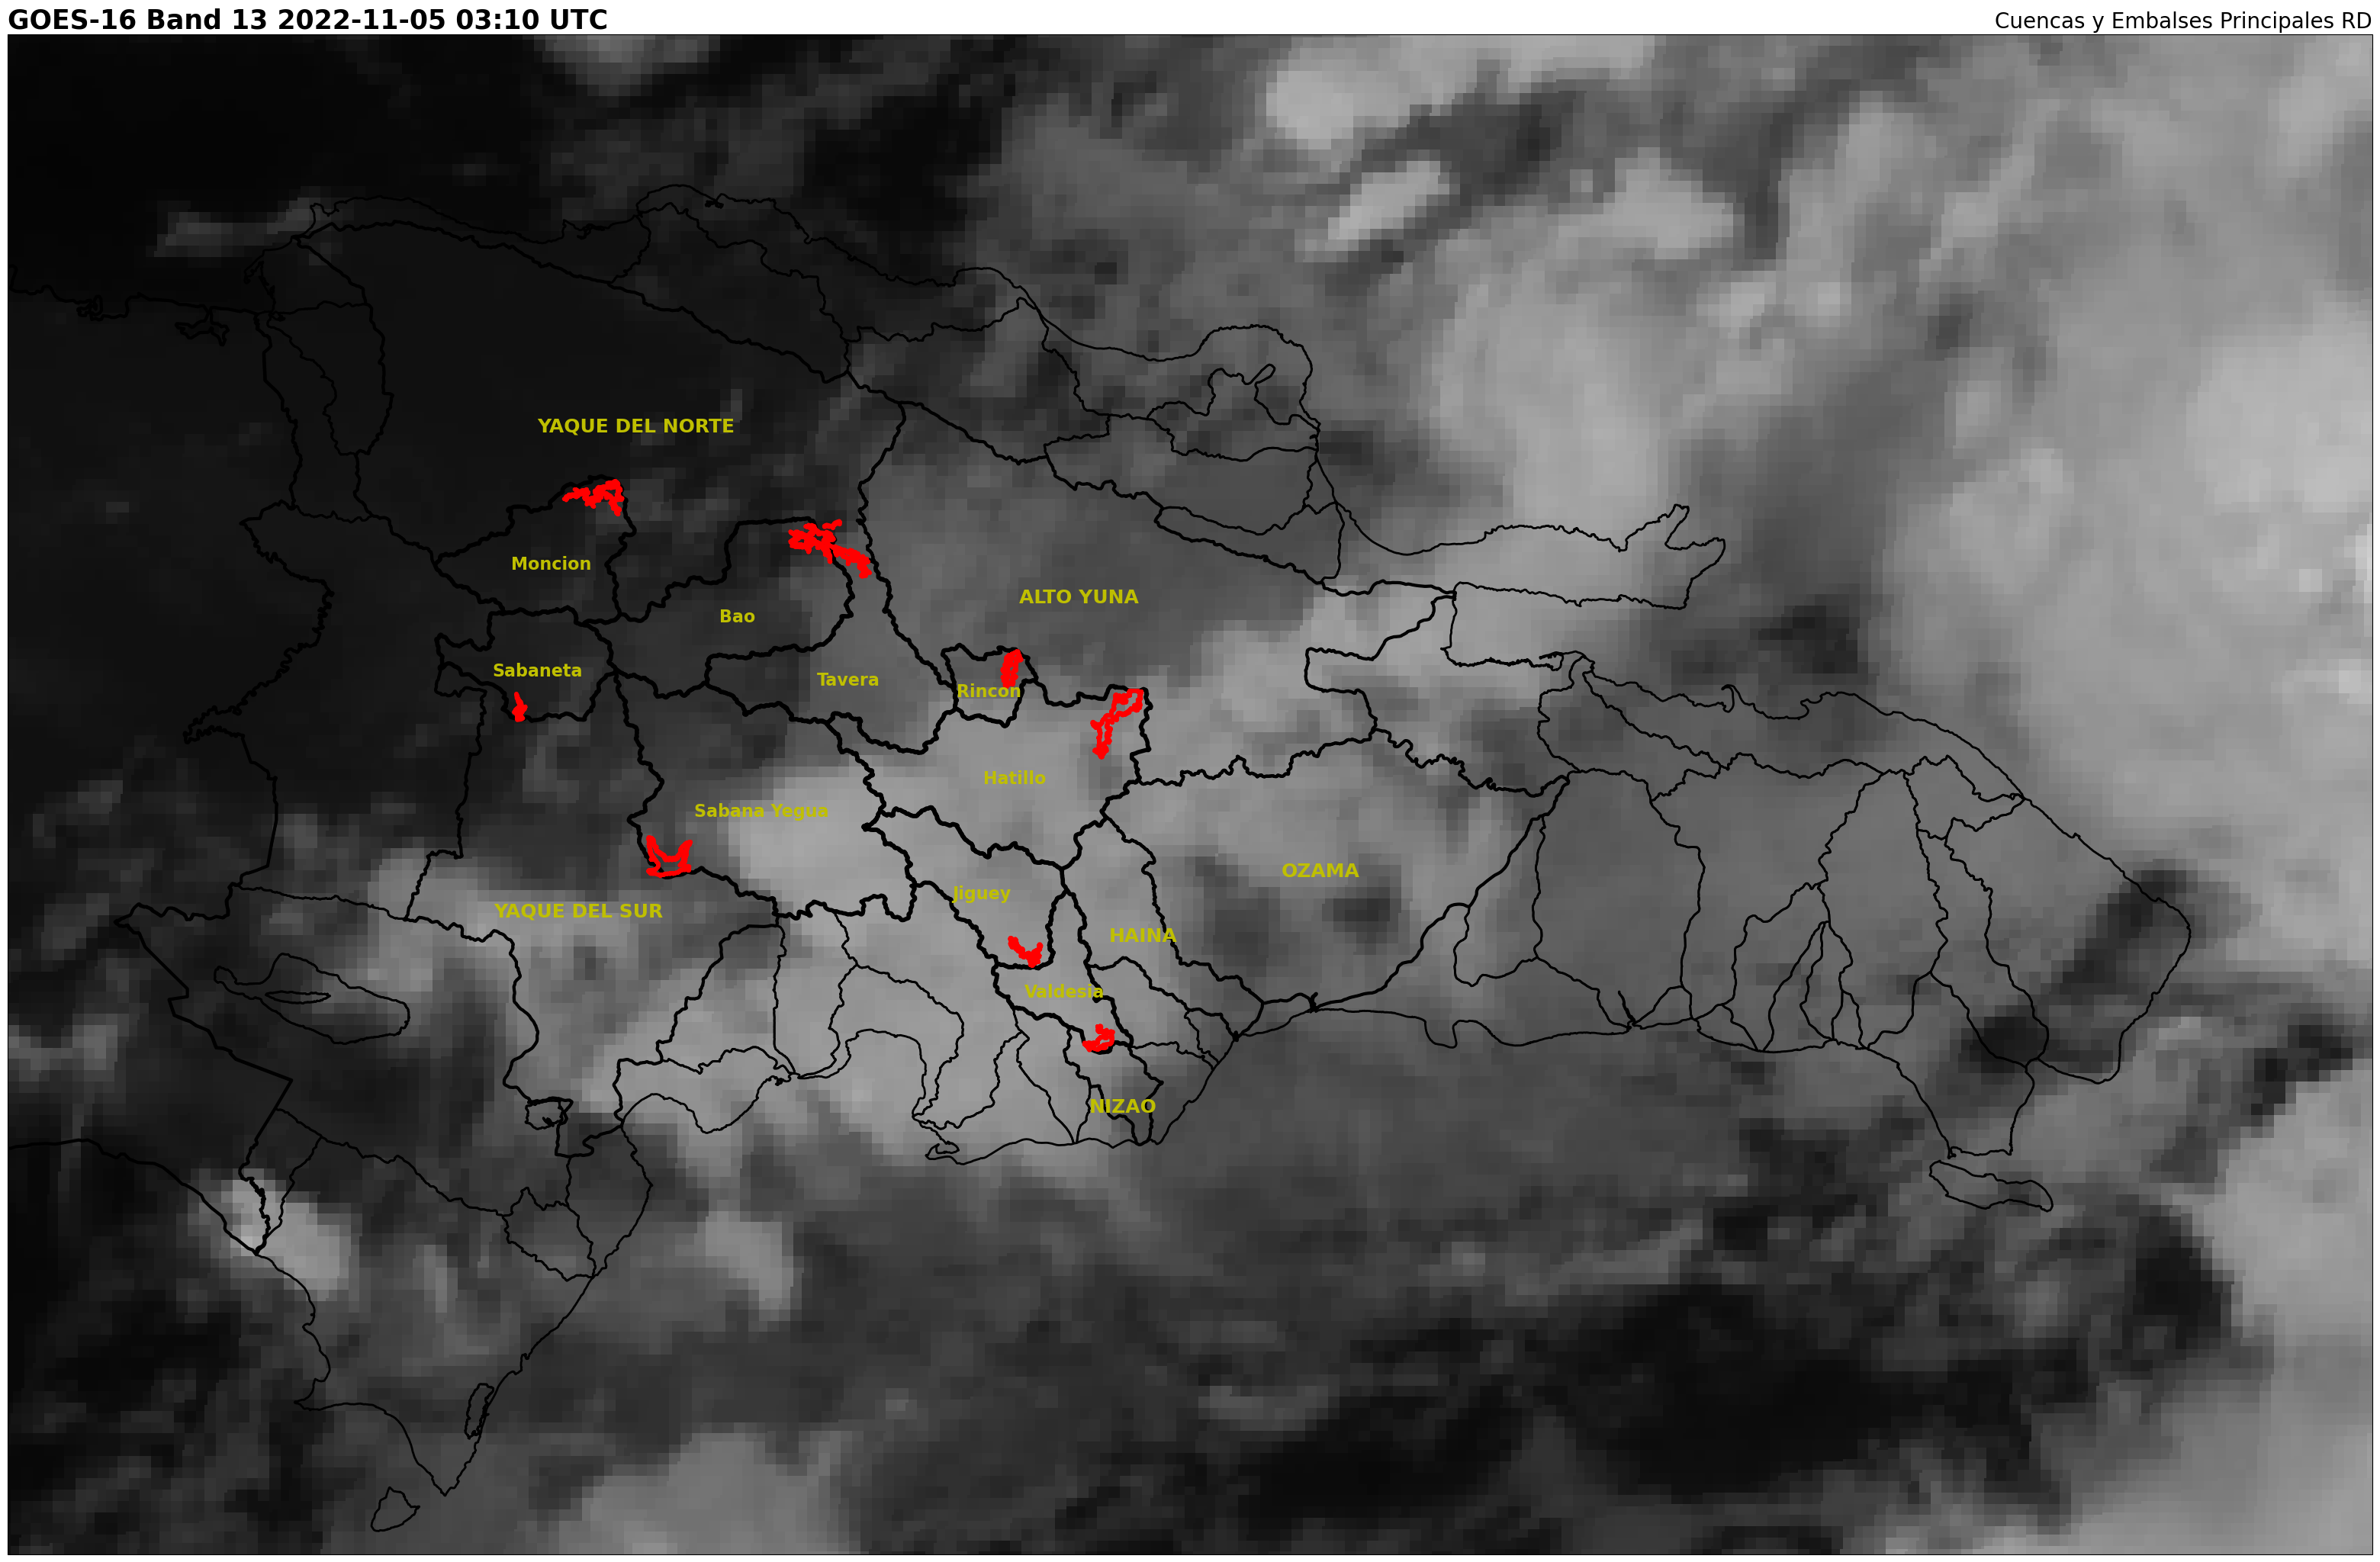

In [1]:
# -----------------------------------------------------------------------------------------------------------
# INPE / CPTEC - Training: Python and GOES-R Imagery: Script 14 - Reprojection with GDAL
# -----------------------------------------------------------------------------------------------------------
# Required modules
import os  # Miscellaneous operating system interfaces
from datetime import datetime  # Basic Dates and time types

import cartopy
import cartopy.crs as ccrs  # Plot maps
import cartopy.io.shapereader as shpreader  # Import shapefiles
import geopandas
import matplotlib.pyplot as plt  # Plotting library
import numpy as np  # Scientific computing with Python
from netCDF4 import Dataset  # Read / Write NetCDF4 files
from osgeo import gdal  # Python bindings for GDAL
from osgeo import osr  # Python bindings for GDAL
from utilities import download_CMI  # Our function for download

# -----------------------------------------------------------------------------------------------------------
# Input and output directories
input = "./content/Samples"
os.makedirs(input, exist_ok=True)
output = "./content/Output"
os.makedirs(output, exist_ok=True)

# Desired extent
extent = [-140.0, 10.0, -60.0, 60.0]  # Min lon, Min lat, Max lon, Max lat

# Datetime to process
yyyymmddhhmn = "20221105310"
band = "13"

# Download the file
file_name = download_CMI(yyyymmddhhmn, band, input)

# -----------------------------------------------------------------------------------------------------------
# Variable
var = "CMI"

# Open the file
img = gdal.Open(f"NETCDF:{input}/{file_name}.nc:" + var)

# Read the header metadata
metadata = img.GetMetadata()
scale = float(metadata.get(var + "#scale_factor"))
offset = float(metadata.get(var + "#add_offset"))
undef = float(metadata.get(var + "#_FillValue"))
dtime = metadata.get("NC_GLOBAL#time_coverage_start")

# Load the data
ds = img.ReadAsArray(0, 0, img.RasterXSize, img.RasterYSize).astype(float)

# Apply the scale, offset and convert to celsius
# ds = (ds * scale + offset) - 273.15
# ds = (ds * scale + offset) * (-1)
ds = ds * scale + offset

# Read the original file projection and configure the output projection
source_prj = osr.SpatialReference()
source_prj.ImportFromProj4(img.GetProjectionRef())

target_prj = osr.SpatialReference()
target_prj.ImportFromProj4("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs")

# Reproject the data
GeoT = img.GetGeoTransform()
driver = gdal.GetDriverByName("MEM")
raw = driver.Create("raw", ds.shape[0], ds.shape[1], 1, gdal.GDT_Float32)
raw.SetGeoTransform(GeoT)
raw.GetRasterBand(1).WriteArray(ds)

# Define the parameters of the output file
options = gdal.WarpOptions(
    format="netCDF",
    srcSRS=source_prj,
    dstSRS=target_prj,
    outputBounds=(extent[0], extent[3], extent[2], extent[1]),
    outputBoundsSRS=target_prj,
    outputType=gdal.GDT_Float32,
    srcNodata=undef,
    dstNodata="nan",
    xRes=0.005,
    yRes=0.005,
    resampleAlg=gdal.GRA_NearestNeighbour,
)

print(options)

# Write the reprojected file on disk
gdal.Warp(f"{output}/{file_name}_ret.nc", raw, options=options)
# -----------------------------------------------------------------------------------------------------------
# Open the reprojected GOES-R image
file = Dataset(f"{output}/{file_name}_ret.nc")
# file = Dataset(f"/home/gustav/data/{file_name}_ret.nc")

# Get the pixel values
data = file.variables["Band1"][:]
# data = data[data < 10]
gamma = 2.2
print("applying gamma corr")
data = np.power(data, 1 / gamma)
print("gamma corr applied")
# data = data*(-1)
# data = np.clip(data, 0.5, 1)
# data.append([0.001])
# -----------------------------------------------------------------------------------------------------------
file_name = None

# img.close()
img = None

ds = None
raw = None

file.close()
file = None

# -----------------------------------------------------------------------------------------------------------

# #-----------------------------------------------------------------------------------------------------------
# # Open the reprojected GOES-R image
# file = Dataset(f'{output}/{file_name}_ret.nc')

# # Get the pixel values
# data = file.variables['Band1'][:]
# #-----------------------------------------------------------------------------------------------------------
# # Choose the plot size (width x height, in inches)
plt.figure(figsize=(40, 40))

# Use the Geostationary projection in cartopy
ax = plt.axes(projection=ccrs.PlateCarree())

# Define the image extent
img_extent = [extent[0], extent[2], extent[1], extent[3]]
ax.set_extent([-72.2, -68, 17.5, 20.2])

# Define the color scale based on the channel
# colormap = "gray_r" # White to black for IR channels
colormap = "gray_r"

# Plot the image
img = ax.imshow(data, origin="upper", extent=img_extent, cmap=colormap)


# --------------------------------------------------------------------------------------------------------------------------
# Add a shapefile
# shapefile = list(shpreader.Reader('/content/ne_10m_admin_1_states_provinces.shp').geometries())
# ax.add_geometries(shapefile, ccrs.PlateCarree(), edgecolor='gold',facecolor='none', linewidth=0.3)

map_crs = ccrs.PlateCarree()
data_crs = ccrs.PlateCarree()
# ------------------------------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------------------------------
# hispaniola_gdf = geopandas.read_file("../shape_files/rd_shapes/vectores/hispaniola.shp")
cuencas_hidro_gdf = geopandas.read_file(
    "../shape_files/rd_shapes/vectores/Cuencas_Hidrograficas_RD.shp"
)
cuencas_presas_gdf = geopandas.read_file(
    "../shape_files/rd_shapes/vectores/Presas-CuencasAporte.shp"
)

silueta_haiti_gdf = geopandas.read_file(
    "../shape_files/rd_shapes/vectores/silueta_haiti.shp"
)


silueta_haiti_gdf = silueta_haiti_gdf.to_crs("EPSG:4326")
cuencas_hidro_full_gdf = cuencas_hidro_gdf.to_crs("EPSG:4326")
cuencas_hidro_gdf = cuencas_hidro_gdf.to_crs("EPSG:4326")
cuencas_presas_gdf = cuencas_presas_gdf.to_crs("EPSG:4326")

cuencas_presas_gdf = cuencas_presas_gdf.drop(
    columns=[
        "ACUEDUCTM3",
        "AREA",
        "PERIMETER",
        "ACRES",
        "HECTARES",
        "Km",
        "ENCLOSED_A",
        "ISLAND_ARE",
        "Id",
        "LAYER",
        "GM_TYPE",
        "PROPOSITO",
        "RIEGO_HA",
        "POTENCIA_M",
        "OPERACIO_1",
        "GEN_GWH_A",
        "REGION_HID",
        "COTA_OPERA",
        "ENCLOSED_1",
        "ENCLOSED_2",
        "ELEVATION",
        "NAME",
        "GM_LAYER",
        "TIPO_PRESA",
        "ALTURA_MTS",
        "RIO",
        "V_DIS_MM3",
        "V_S_BATMM3",
    ]
)

nombres = [
    "Bao",
    "Tavera",
    "Sabaneta",
    "Sabana Yegua",
    "Rincon",
    "Moncion",
    "Jiguey",
    "Valdesia",
    "Hatillo",
    "Moncion",
    "Tavera-bao",
    "Valdesia",
    "Hatillo",
    "Rincon",
    "",
    "Tavera-Bao",
    "Jiguey",
    "Sabaneta",
    "Sabana Yegua",
]

cuencas = [
    "Yaque del Norte",
    "Yaque del Norte",
    "Yaque del Sur",
    "Yaque del Sur",
    "Yuna-Camu",
    "Yaque del Norte",
    "Nizao",
    "Nizao",
    "Yuna-Camu",
    "Yaque del Norte",
    "Yaque del Norte",
    "Nizao",
    "Yuna-Camu",
    "Yuna-Camu",
    "",
    "Yaque del Norte",
    "Nizao",
    "Yaque del Sur",
    "Yaque del Sur",
]

cuencas_presas_gdf["Nombre"] = nombres
cuencas_presas_gdf["Cuenca"] = cuencas

cuencas_presas_gdf = cuencas_presas_gdf[["Nombre", "Cuenca", "geometry"]]

cuencas_hidro_gdf = cuencas_hidro_gdf.loc[[28, 47, 48, 50, 54, 55]]

# cuencas_presas_gdf = cuencas_presas_gdf.drop(14)
cuencas_presas_gdf_ = cuencas_presas_gdf[:9]


inside_coords_lat = [
    18.30988448762174,
    18.65760134123338,
    18.72853130712674,
    19.215888515208702,
    19.5201306566612,
    18.614190289673694,
]

inside_coords_lon = [
    -70.2187673247053,
    -71.1865047734343,
    -69.86783027131499,
    -70.2972762654869,
    -71.08462067184799,
    -70.1829676153929,
]

cuencas_hidro_gdf["INSIDE_COORDS_LAT"] = inside_coords_lat
cuencas_hidro_gdf["INSIDE_COORDS_LON"] = inside_coords_lon
cuencas_hidro_gdf = cuencas_hidro_gdf[
    ["NOMBRE", "INSIDE_COORDS_LAT", "INSIDE_COORDS_LON", "geometry"]
]

cuencas_hidro_gdf.apply(
    lambda x: ax.annotate(
        text=x.NOMBRE,
        xy=(x.INSIDE_COORDS_LON, x.INSIDE_COORDS_LAT),
        fontsize=18,
        ha="center",
        color="y",
        weight="heavy",
        va="top",
    ),
    axis=1,
)
cuencas_presas_gdf_.apply(
    lambda x: ax.annotate(
        text=x.Nombre,
        xy=x.geometry.centroid.coords[0],
        fontsize=16,
        ha="center",
        color="y",
        weight="heavy",
        va="top",
    ),
    axis=1,
)

ax.add_geometries(
    cuencas_hidro_gdf["geometry"],
    crs=data_crs,
    facecolor="none",
    edgecolor="black",
    linewidth=3,
)

ax.add_geometries(
    cuencas_presas_gdf["geometry"][:9],
    crs=data_crs,
    facecolor="none",
    edgecolor="black",
    linewidth=4,
)

ax.add_geometries(
    cuencas_presas_gdf["geometry"][9:],
    crs=data_crs,
    facecolor="none",
    edgecolor="red",
    linewidth=4,
)
ax.add_geometries(
    silueta_haiti_gdf["geometry"],
    crs=data_crs,
    facecolor="none",
    edgecolor="black",
    linewidth=3,
)

ax.add_geometries(cuencas_hidro_full_gdf['geometry'], crs=data_crs, facecolor='none',
                  edgecolor='black', linewidth=2)
# ------------------------------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------------------------------


# Add coastlines, borders and gridlines
# ax.add_feature(cartopy.feature.BORDERS, edgecolor='white', linewidth=0.5)
# ax.add_geometries(shapefile, ccrs.PlateCarree(), edgecolor='white',facecolor='none', linewidth=1.0)
# gl = ax.gridlines(crs=ccrs.PlateCarree(), color='gray', alpha=1.0, linestyle='--', linewidth=0.25, xlocs=np.arange(-180, 180, 5), ylocs=np.arange(-90, 90, 5), draw_labels=True)
# gl.top_labels = False
# gl.right_labels = False

# --------------------------------------------------------------------------------------------------------------------------
# Add a colorbar
# plt.colorbar(img, label='Brightness Temperatures (°C)', extend='both', orientation='horizontal', pad=0.05, fraction=0.05)

# Extract date
date = datetime.strptime(dtime, "%Y-%m-%dT%H:%M:%S.%fZ")

# Add a title
plt.title(
    "GOES-16 Band 13 " + date.strftime("%Y-%m-%d %H:%M") + " UTC",
    fontweight="bold",
    fontsize=25,
    loc="left",
)
plt.title("Cuencas y Embalses Principales RD", fontsize=20, loc="right")
# -----------------------------------------------------------------------------------------------------------
# Save the image
plt.gcf()
plt.savefig(f"output", bbox_inches="tight", pad_inches=0, dpi=300)

# Show the image
plt.show()